In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb 25 01:32:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
need_to_install = True
need_to_load = True
need_to_load_ext = True

# Install and import

In [ ]:
if need_to_install:
  !pip install timm==0.6.12
  !pip install wandb==0.13.3
  !pip install transformers
  !pip install monai==1.0.1
  !pip install iterative-stratification
  !pip install torchcontrib
  !pip install einops
  !pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e746e1c9906e14fc8a0390c132fe150f7b62394beca1023fb86b6f5da4d376c0
  Stored in directory: /root/.cache/pip/wh

In [ ]:
import sys
code_path = '/content/drive/MyDrive/colab/RSNA_BCD/code/'

sys.path.insert(0, code_path)

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import wandb
import torch
import pandas as pd

import matplotlib.pyplot as plt

from RSNA_utils.data import prepare_loaders
from RSNA_utils.models import get_model
from RSNA_utils.pipeline import train_loop, train_loop_full_set
from RSNA_utils.utils import get_logger, class2dict

# Config

In [ ]:
# ====================================================
# Config
# ====================================================
class CFG:
    ####################
    # MAIN
    ####################
    wandb = True
    wandb_project = 'RSNA_cancer'
    competition = 'RSNA_SMBCD'
    wb_group = None
    exp_name = 'NeXTViT-S_1536LUTfit_pm10_pw3_LMF_ext_1'
    base_path = '/content/drive/MyDrive/colab/RSNA_BCD/'

    seed = 13551
    train = True
    debug = False
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ####################
    # DATA
    ####################

    use_external = True
    external_multiplier = 2 #2
    dnt_use_ext_after = 999 # 9
    
    img_size = 1024
    image_size = (1536, 1024) # for transformer
    dataset = 'v1'  # ['v1', 'v2', 'transformer', 'transformer_stripes_MIP' ,'stripes', 'transformer_stripes']
    use_meta = False # False
    pos_multiplier = 10
    num_workers = 12
    train_bs = 6   # b0 24, b2, b4 10
    valid_bs = 8
    n_fold = 4
    trn_fold = [1] # [0,1,2,3]
    
    interesing_cols = ['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
               'cancer', 'implant', 'machine_id', 'difficult_negative_case', 'path', 'fold']
    
    ####################
    # AUGMENTATIONS
    ####################     [CURRENT BEST]
    change_aug = False
    use_aug_prob = 0.85          #0.85

    flip_prob_0 = 0.5            #0.5
    flip_prob_1 = 0.5            #0.5
    
    zoom_prob_0 = 0.35           #0.35
    zoom_prob_1 = 0.4            #0.4
    
    rotate_prob_0 = 0.35         #0.35
    rotate_prob_1 = 0.4          #0.4
    
    contr_prob_0 = 0.45          #0.45
    contr_prob_1 = 0.45          #0.45

    elastic_prob_0 = 0.2         #0.3
    elastic_prob_1 = 0.2        #0.35

    affine_prob_0 = 0.35         #0.35
    affine_prob_1 = 0.4          #0.4

    drop_prob_0 = 0.35           #0.35
    drop_prob_1 = 0.35           #0.35

    gibbs_prob_0 = 0.2
    gibbs_prob_1 = 0.25

    gaus_prob_0 = 0.2
    gaus_prob_1 = 0.25

    stripe_prob = 0.7    # 0.7 

    '''gap_dict = {1: 350,
                2: 300,
                3: 250,
                4: 200,
                5: 150,
                6: 150,
                7: 150} #100}'''

    gap_dict = {1: 350,
                2: 350,
                3: 300,
                4: 300,
                5: 300,
                6: 300,
                7: 250,
                8: 200} #100

    circle_aug_prob = 0.15

    ####################
    # MODEL
    ####################
    deep_supervision = False
    deep_supervision_out = False
    model = 'nextvit_s'  # ['v0', 'v1', 'v2', 'v3', 'nextvit', 'effv2_deepsuper', 'v0_deepsuper', 'MIP_transformer', 'nextvit_deepsuper']  # 'v0'
    backbone = "tf_efficientnet_b0"  # tf_efficientnet_b0  5.29M   tf_efficientnet_b2 9.11M  tf_efficientnet_b4 19.34M   tf_efficientnetv2_s
    pretrained = True
    use_act = False
    drop_rate = 0.1
    in_channels = 3

    mip_ckpt = '/content/drive/MyDrive/colab/RSNA_BCD/results/effb0_2048sq_pm10_pw5_LMF_ext6_dr0.12_1/checkpoints/v0_deepsuper_fold1_best_CURBEST_0.4261_raw_0.325.pth'
    mip_heads = 4
    mip_drop = 0.25

    ####################
    # TRAIN
    ####################
    FULL_TRAIN = False # False
    patient_wise = False  ### NEW !!!!!! True - patient wise split
    apex = True
    
    eval_after = 0
    eval_every = 1
    eval_always_after = 1

    finetune = False
    finetune_path = f'/content/drive/MyDrive/colab/RSNA_BCD/results/{exp_name}/checkpoints/v0_deepsuper_fold0_best.pth'
    finetune_fold = 0
    finetune_sched_opt = True
    finetune_epoch = 2
    finetune_change_seed = True

    dist_plot_valid = True
    VALID_SINGLE = True

    ####################
    # LOSS
    ####################
    loss = 'LMF'  # ['bce', 'diff_bce', 'LMF', 'LMF_EXT']
    pos_wgt = 2.5 #       # 2
    change_pos_wgt = False
    dif_wgt = 0.7      # 0.7

    focal_alpha = 0.3
    focal_gamma = 2.
    ldam_max_m = 0.5
    ldam_s = 2
    w_ldam = 1
    w_focal = 7
    w_bce = 1

    # Scheduler step 1

    scheduler = 'onecycle' #'onecycle'   #  ["linear", "cosine", "cosine_restart", "onecycle", "simple_cosine" ]
    onecycle_start = 0.05  # 1337
    onecycle_m = 1.1 # чтобы лр не до конца опускался, макс количество степов увеличивает
    num_cycles = 0.488 #1 
    num_warmup_steps = 100

    # Loop step 1

    epochs = 8   # b0 16, b2 14, b4 12
    use_restart = True # True
    rest_thr_ = 0.13 #0.05
    rest_epoch = 3 #int(epochs//2)
    iter4eval = 4

    save_for_future = True
    save_future_epoch = epochs - 2

    # LR, optimizer step 1

    lr = 2e-5 #  4e-4
    min_lr = 1e-6
    eps = 1e-8 
    betas = (0.9, 0.999)
    weight_decay = 0.01
    gradient_accumulation_steps = 1 #1
    optimizer = "AdamW" #'AdamW'


os.makedirs(CFG.base_path + 'results/', exist_ok=True)
os.makedirs(CFG.base_path + 'results/' + CFG.exp_name, exist_ok=True)
os.makedirs(CFG.base_path + 'results/' + CFG.exp_name + '/checkpoints', exist_ok=True)
CFG.save_path = CFG.base_path + 'results/' + CFG.exp_name + '/checkpoints/'
with open(CFG.base_path + 'results/' + CFG.exp_name + '/CFG.txt', 'w') as f:
    for key, value in CFG.__dict__.items():
        f.write('%s:%s\n' % (key, value))

# Logging

In [ ]:
if CFG.debug:
    CFG.wandb = False
if CFG.wandb:
    wandb.init(project=CFG.wandb_project,
               name=CFG.exp_name,
               config=class2dict(CFG),
               group=CFG.wb_group,
               job_type="train",
               dir=CFG.base_path)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data Preparation

In [ ]:
if need_to_load:
    import time
    st = time.time()

    #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_square_2048.zip data.zip
    !cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_trans_LUT_cutter_1536x1024.zip data.zip
    #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_trans_LUT_cutter_2048sq.zip data.zip
    #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_cutter_2048sq.zip data.zip

    !unzip data.zip

    !rm -r data.zip

    time_elapsed = time.time() - st

    print('\nCopy and unzip complete in {:.0f}h {:.0f}m {:.0f}s'.format(
            time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
print()

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: output_trans_LUT_cutter_1536x1024/25388/537242624.png  
  inflating: output_trans_LUT_cutter_1536x1024/25388/1687308761.png  
   creating: output_trans_LUT_cutter_1536x1024/10335/
  inflating: output_trans_LUT_cutter_1536x1024/10335/1376911215.png  
  inflating: output_trans_LUT_cutter_1536x1024/10335/1152574310.png  
  inflating: output_trans_LUT_cutter_1536x1024/10335/10344577.png  
  inflating: output_trans_LUT_cutter_1536x1024/10335/817917685.png  
  inflating: output_trans_LUT_cutter_1536x1024/10335/1765678748.png  
  inflating: output_trans_LUT_cutter_1536x1024/10335/1792651296.png  
   creating: output_trans_LUT_cutter_1536x1024/45034/
  inflating: output_trans_LUT_cutter_1536x1024/45034/221423044.png  
  inflating: output_trans_LUT_cutter_1536x1024/45034/874804099.png  
  inflating: output_trans_LUT_cutter_1536x1024/45034/47098948.png  
  inflating: output_trans_LUT_cutter_1536x1024/45034/759171445

In [ ]:
#IMG_PATH = f'/content/output_square_2048/'
IMG_PATH = f'/content/output_trans_LUT_cutter_1536x1024/' 
#IMG_PATH = f'/content/output_trans_LUT_cutter_2048sq/'
#IMG_PATH = f'/content/output_cutter_2048sq/'


train = pd.read_csv(f'{CFG.base_path}/train.csv')
test = pd.read_csv(f'{CFG.base_path}/test.csv')

train['age'].fillna(int(train['age'].mean()), inplace=True)
train['age'] = train['age'] / 100

pathes = []
for i in range(len(train)):
    sample = train.loc[i]
    path = IMG_PATH + f'/{sample["patient_id"]}/{sample["image_id"]}.png'
    pathes.append(path)
train['path'] = pathes
train['prediction_id'] = train['patient_id'].astype(str) + "_" + train['laterality']
print(train.shape)
display(train.head())

(54706, 16)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,prediction_id
0,2,10006,462822612,L,CC,0.61,0,0,0,NaN,0,NaN,29,False,/content/output_trans_LUT_cutter_1536x1024//10...,10006_L
1,2,10006,1459541791,L,MLO,0.61,0,0,0,NaN,0,NaN,29,False,/content/output_trans_LUT_cutter_1536x1024//10...,10006_L
2,2,10006,1864590858,R,MLO,0.61,0,0,0,NaN,0,NaN,29,False,/content/output_trans_LUT_cutter_1536x1024//10...,10006_R
3,2,10006,1874946579,R,CC,0.61,0,0,0,NaN,0,NaN,29,False,/content/output_trans_LUT_cutter_1536x1024//10...,10006_R
4,2,10011,220375232,L,CC,0.55,0,0,0,0.0,0,NaN,21,True,/content/output_trans_LUT_cutter_1536x1024//10...,10011_L


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

split = StratifiedGroupKFold(CFG.n_fold, random_state=142, shuffle=True) #rs = 42

bad_mb = [1760744211, 1743461841, 166085523, 1110010839, 840036202, 673653549, 1133144412,
         764545189, 1031853445, 1273092690, 1942326353, 597771506, 746249759, 73792921,  # poseldnie 2 hz
         694341224, 1942326353, 1648448368, 136057818, 1997037350, 1906555893, 31473718]

train = train[~train.image_id.isin(np.array(bad_mb))].reset_index(drop=True)

#train = train[:1000]

for k, (_, test_idx) in enumerate(split.split(train, train.cancer, groups=train.prediction_id)):
    train.loc[test_idx, 'fold'] = k

train.fold = train.fold.astype(int)
display(train.groupby('fold').size())

fold
0    13739
1    13607
2    13679
3    13661
dtype: int64

In [ ]:
'''import glob
files_ = glob.glob(IMG_PATH + '/*/*.png')

hzzz = []
for i in range(len(train)):
    if not os.path.exists(train.loc[i, 'path']):
        hzzz.append(train.loc[i, 'path'])
        print(train.loc[i, 'path'])
        print('Label: ', train.loc[i, 'cancer'])
train = train[~train.path.isin(hzzz)].reset_index(drop=True)

print(f'Total files: {len(files_)} | Not Found Files: {len(hzzz)} | Rest train shape: {len(train)}')
display(train.head(3))'''

"import glob\nfiles_ = glob.glob(IMG_PATH + '/*/*.png')\n\nhzzz = []\nfor i in range(len(train)):\n    if not os.path.exists(train.loc[i, 'path']):\n        hzzz.append(train.loc[i, 'path'])\n        print(train.loc[i, 'path'])\n        print('Label: ', train.loc[i, 'cancer'])\ntrain = train[~train.path.isin(hzzz)].reset_index(drop=True)\n\nprint(f'Total files: {len(files_)} | Not Found Files: {len(hzzz)} | Rest train shape: {len(train)}')\ndisplay(train.head(3))"

In [ ]:
import glob
if CFG.use_external:
    if need_to_load_ext:
        import time
        st = time.time()

        !cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_trans_LUT_cutter_1536x1024_EXT.zip data_ext.zip
        #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_cutter_2048sq_EXT.zip data_ext.zip
        #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/output_trans_LUT_cutter_2048sq_EXT.zip data_ext.zip
        !unzip data_ext.zip

        #!cp /content/drive/MyDrive/colab/RSNA_BCD/DATA/square_2048_EXTERNAL/square_2048_EXTERNAL.zip data_ext.zip
        #import zipfile
        #with zipfile.ZipFile("data_ext.zip","r") as zip_ref:
        #    zip_ref.extractall("square_2048_EXT")

        !rm -r data_ext.zip

        time_elapsed = time.time() - st

        print('\nCopy and unzip complete in {:.0f}h {:.0f}m {:.0f}s'.format(
                time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
        


    external_df = pd.read_csv('/content/drive/MyDrive/colab/RSNA_BCD/DATA/square_2048_EXTERNAL/external_train.csv')
    external_df['laterality'] = external_df['laterality'].apply(lambda x: x[0])


    #IMG_PATH_EXT = '/content/square_2048_EXT/'
    IMG_PATH_EXT = '/content/output_trans_LUT_cutter_1536x1024_EXT/'
    #IMG_PATH_EXT = '/content/output_cutter_2048sq_EXT/'
    #IMG_PATH_EXT = '/content/output_trans_LUT_cutter_2048sq_EXT/'

    all_fols = os.listdir(IMG_PATH_EXT)


    external_df['path'] = ['' for _ in range(len(external_df))]
    external_df['image_id'] = ['' for _ in range(len(external_df))]

    for p in external_df['patient_id'].unique():
        p_df = external_df[external_df.patient_id == p]
        p_df_index = p_df.index
        p_df = p_df.reset_index(drop=True)

        ids = [x.split('_')[-1] for x in all_fols if p in x]

        if len(ids) != len(p_df):
            print(f'ALARM ON {p}')

        pathes, img_ids = [], []
        for id in ids:
            pth_ = glob.glob(IMG_PATH_EXT + f'{p}_{id}/*.png')[0]
            img_ids.append(id)
            pathes.append(pth_)

        external_df.loc[p_df_index, 'path'] = pathes
        external_df.loc[p_df_index, 'image_id'] = img_ids

    external_df['fold'] = (np.ones(len(external_df)) * 999).astype('int')
    external_df['difficult_negative_case'] = [False for _ in range(len(external_df))]

    external_df = pd.concat([external_df for _ in range(CFG.external_multiplier)]).reset_index(drop=True)

    print(external_df.shape)
    external_df.head()

    train = pd.concat([train, external_df]).reset_index(drop=True)
    print(train.shape)

Archive:  data_ext.zip
   creating: output_trans_LUT_cutter_1536x1024_EXT/
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_00987_706/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_00987_706/706.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_00719_983/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_00719_983/patient_id_983.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_01100_374/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_01100_374/374.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_00316_185/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_00316_185/185.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_02522_619/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_02522_619/619.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_01418_1220/
  inflating: output_trans_LUT_cutter_1536x1024_EXT/P_01418_1220/patient_id_1220.png  
   creating: output_trans_LUT_cutter_1536x1024_EXT/P_00088_147/
  inflating: o

# Run Training

========== Fold: 1 training ==========
INFO:RSNA_utils.utils:========== Fold: 1 training ==========


> SEEDING DONE
Size of train dataset: 51797  
class 0: 40282 | class 1: 11515
Size of valid dataset: 13607 
class 0: 13247 | class 1: 360
initialize_weights...
Epoch 1/8 | Fold 1


Ep.1 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Ep.1 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'max', 'variant': 2, 'threshold': 0.675, 'score': 0.3730886850152905}
Best RAW score: 0.12419673389986086
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6, 'score': 0.31117021276595747}
Best RAW score: 0.1256278559695598
PLOT FOR BASE


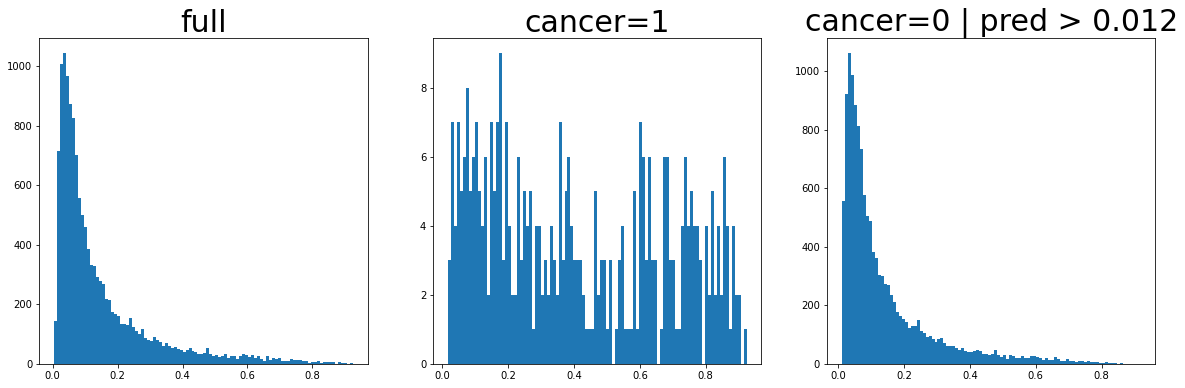

Epoch 1 - avg_train_loss: 1.80547  avg_val_loss: 0.50311  time: 3978s
INFO:RSNA_utils.utils:Epoch 1 - avg_train_loss: 1.80547  avg_val_loss: 0.50311  time: 3978s
Epoch 1 - Score: 0.31117 | RAW score: 0.12563
INFO:RSNA_utils.utils:Epoch 1 - Score: 0.31117 | RAW score: 0.12563
Best RAW Score Updated 0.00000 -->> 0.12563 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.00000 -->> 0.12563 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6, 'score': 0.31117021276595747}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6, 'score': 0.31117021276595747}
||||||||| Best Score Updated 0.00000 -->> 0.31117 | Model Saved |||||||||
INFO:RSNA_utils.utils:||||||||| Best Score Updated 0.00000 -->> 0.31117 | Model Saved |||||||||
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6, 'score': 0.31117021276595747}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6, 'score': 0.31117021276595747}


Epoch 2/8 | Fold 1


Ep.2 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Ep.2 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'max', 'variant': 2, 'threshold': 0.755, 'score': 0.3853820598006645}
Best RAW score: 0.18069155278076957
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.755, 'score': 0.3054545454545454}
Best RAW score: 0.17776967628118756
PLOT FOR BASE


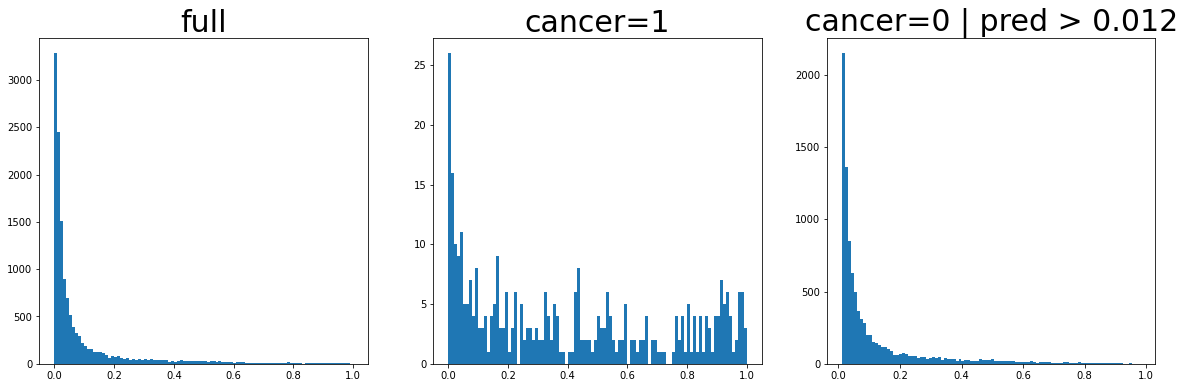

Epoch 2 - avg_train_loss: 0.85291  avg_val_loss: 0.50909  time: 3959s
INFO:RSNA_utils.utils:Epoch 2 - avg_train_loss: 0.85291  avg_val_loss: 0.50909  time: 3959s
Epoch 2 - Score: 0.30545 | RAW score: 0.17777
INFO:RSNA_utils.utils:Epoch 2 - Score: 0.30545 | RAW score: 0.17777
Best RAW Score Updated 0.12563 -->> 0.17777 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.12563 -->> 0.17777 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.755, 'score': 0.3054545454545454}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.755, 'score': 0.3054545454545454}
Score NOT updated. Current best: 0.3112
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3112


Epoch 3/8 | Fold 1


Ep.3 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Ep.3 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.455, 'score': 0.45222929936305734}
Best RAW score: 0.1853288951924234
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.555, 'score': 0.3161856963613551}
Best RAW score: 0.17931286677606545
PLOT FOR BASE


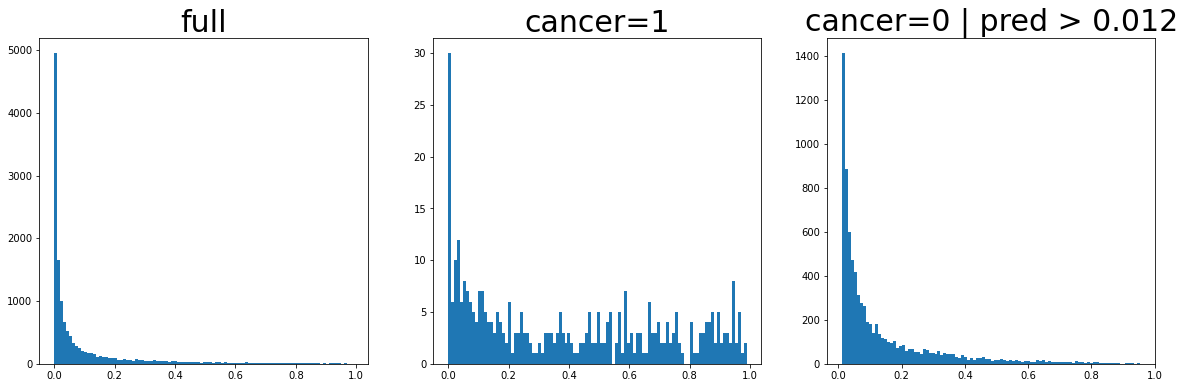

Epoch 3 - avg_train_loss: 0.50499  avg_val_loss: 0.48009  time: 3966s
INFO:RSNA_utils.utils:Epoch 3 - avg_train_loss: 0.50499  avg_val_loss: 0.48009  time: 3966s
Epoch 3 - Score: 0.31619 | RAW score: 0.17931
INFO:RSNA_utils.utils:Epoch 3 - Score: 0.31619 | RAW score: 0.17931
Best RAW Score Updated 0.17777 -->> 0.17931 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.17777 -->> 0.17931 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.555, 'score': 0.3161856963613551}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.555, 'score': 0.3161856963613551}
||||||||| Best Score Updated 0.31117 -->> 0.31619 | Model Saved |||||||||
INFO:RSNA_utils.utils:||||||||| Best Score Updated 0.31117 -->> 0.31619 | Model Saved |||||||||
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.555, 'score': 0.3161856963613551}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.555, 'score': 0.31618569636135

Epoch 4/8 | Fold 1


Ep.4 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Eval on step: 27322


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'max', 'variant': 2, 'threshold': 0.715, 'score': 0.37857142857142856}
Best RAW score: 0.18256139618325273
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.54, 'score': 0.3070652173913044}
Best RAW score: 0.17810997409501067
PLOT FOR BASE


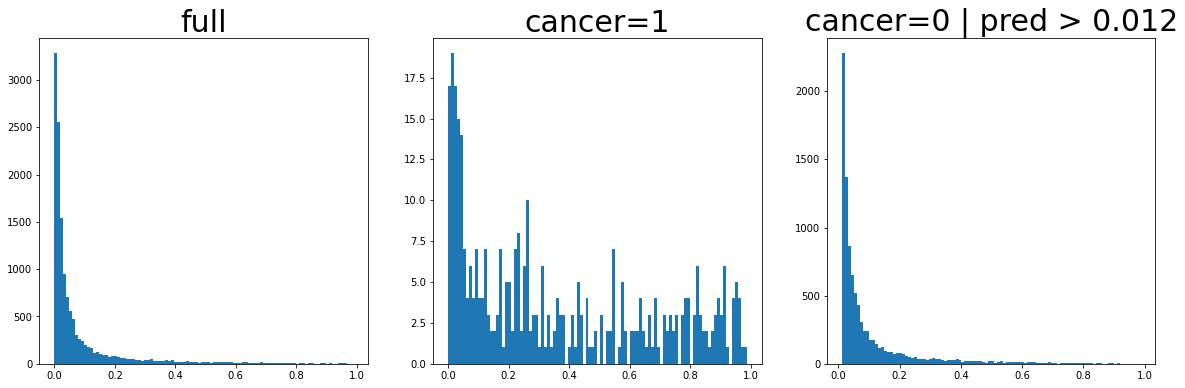

avg_val_loss: 0.43817 val_score: 0.30707 raw_score: 0.17811
INFO:RSNA_utils.utils:avg_val_loss: 0.43817 val_score: 0.30707 raw_score: 0.17811
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 28760


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'max', 'variant': 2, 'threshold': 0.7000000000000001, 'score': 0.38129496402877694}
Best RAW score: 0.21061572827798428
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.55, 'score': 0.3119266055045871}
Best RAW score: 0.20277524727484922
PLOT FOR BASE


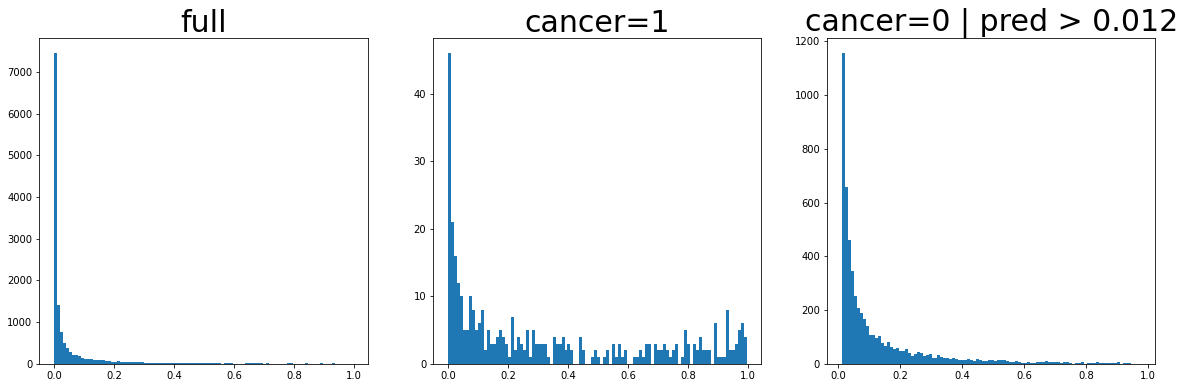

avg_val_loss: 0.49264 val_score: 0.31193 raw_score: 0.20278
INFO:RSNA_utils.utils:avg_val_loss: 0.49264 val_score: 0.31193 raw_score: 0.20278
Best RAW Score Updated 0.17931 -->> 0.20278 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.17931 -->> 0.20278 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.55, 'score': 0.3119266055045871}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.55, 'score': 0.3119266055045871}
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 30198


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.375, 'score': 0.3761194029850746}
Best RAW score: 0.1807743706426238
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.585, 'score': 0.2954898911353033}
Best RAW score: 0.17652477509462214
PLOT FOR BASE


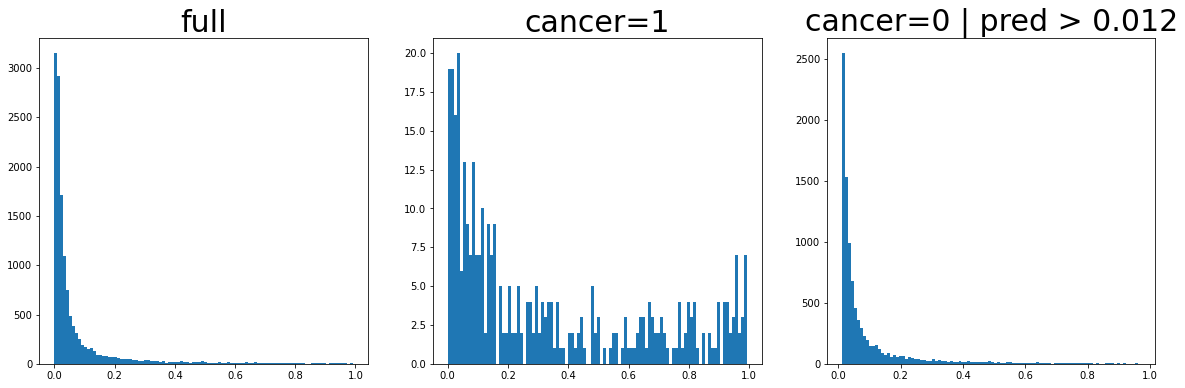

avg_val_loss: 0.46124 val_score: 0.29549 raw_score: 0.17652
INFO:RSNA_utils.utils:avg_val_loss: 0.46124 val_score: 0.29549 raw_score: 0.17652
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 31636


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.46, 'score': 0.3849056603773585}
Best RAW score: 0.20460929862403848
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.56, 'score': 0.3153526970954356}
Best RAW score: 0.1989678186127246
PLOT FOR BASE


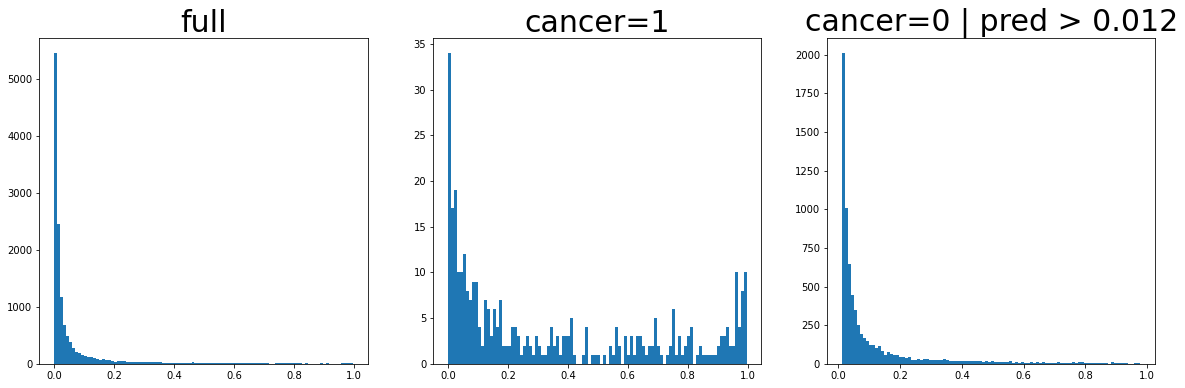

avg_val_loss: 0.49949 val_score: 0.31535 raw_score: 0.19897
INFO:RSNA_utils.utils:avg_val_loss: 0.49949 val_score: 0.31535 raw_score: 0.19897
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 33074


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.485, 'score': 0.36496350364963503}
Best RAW score: 0.1901019328596914
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.6950000000000001, 'score': 0.29480737018425457}
Best RAW score: 0.18185301362402978
PLOT FOR BASE


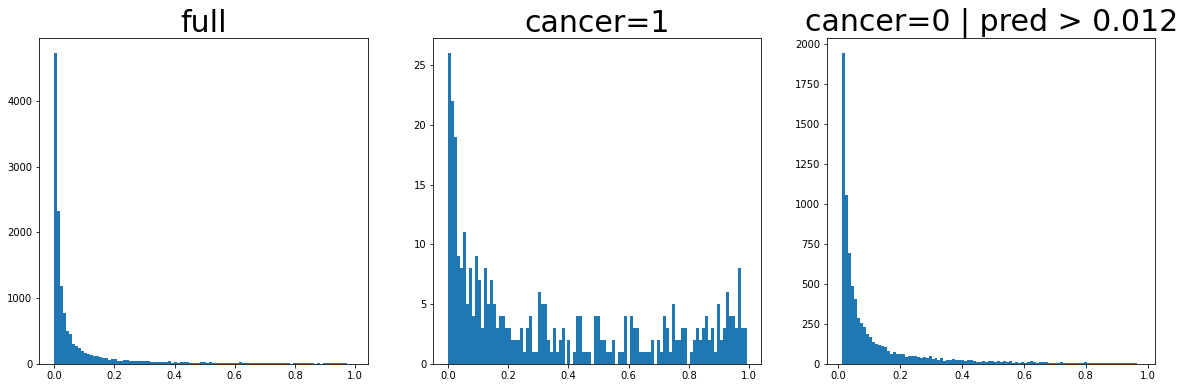

avg_val_loss: 0.52119 val_score: 0.29481 raw_score: 0.18185
INFO:RSNA_utils.utils:avg_val_loss: 0.52119 val_score: 0.29481 raw_score: 0.18185
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Ep.4 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.315, 'score': 0.3909774436090226}
Best RAW score: 0.2134968913220415
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.34500000000000003, 'score': 0.2837078651685393}
Best RAW score: 0.1957022685268798
PLOT FOR BASE


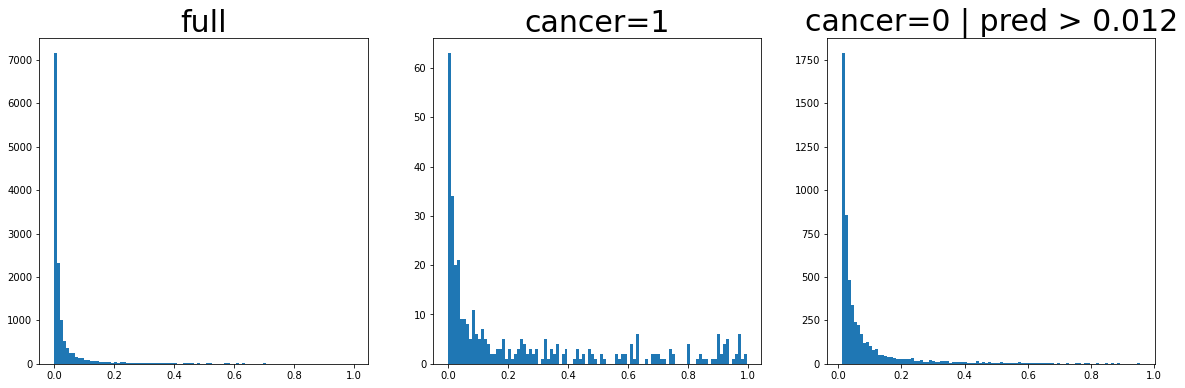

Epoch 4 - avg_train_loss: 0.30946  avg_val_loss: 0.49368  time: 5847s
INFO:RSNA_utils.utils:Epoch 4 - avg_train_loss: 0.30946  avg_val_loss: 0.49368  time: 5847s
Epoch 4 - Score: 0.28371 | RAW score: 0.19570
INFO:RSNA_utils.utils:Epoch 4 - Score: 0.28371 | RAW score: 0.19570
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Epoch 5/8 | Fold 1


Ep.5 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Eval on step: 36686


Ep.5 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.31, 'score': 0.4026402640264027}
Best RAW score: 0.2258195049570249
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.5800000000000001, 'score': 0.30687830687830686}
Best RAW score: 0.2128856889391766
PLOT FOR BASE


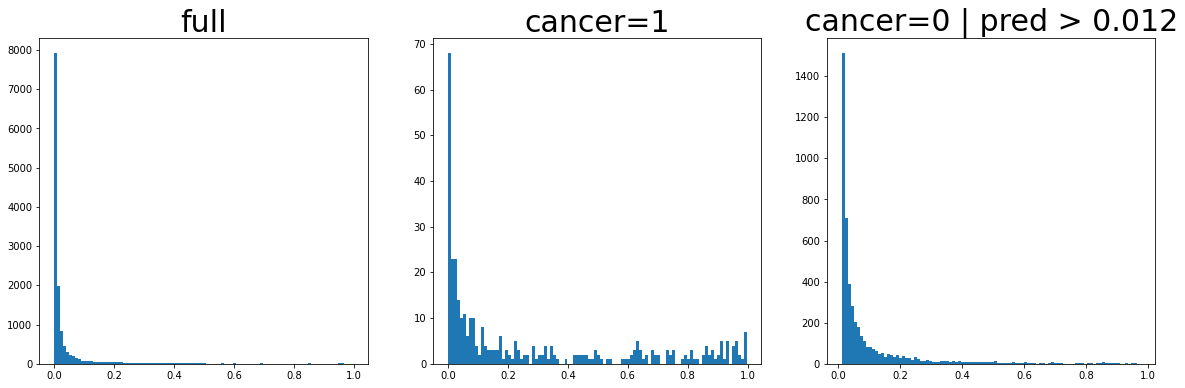

avg_val_loss: 0.53084 val_score: 0.30688 raw_score: 0.21289
INFO:RSNA_utils.utils:avg_val_loss: 0.53084 val_score: 0.30688 raw_score: 0.21289
Best RAW Score Updated 0.20278 -->> 0.21289 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.20278 -->> 0.21289 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.5800000000000001, 'score': 0.30687830687830686}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.5800000000000001, 'score': 0.30687830687830686}
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 38844


Ep.5 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.35000000000000003, 'score': 0.41025641025641024}
Best RAW score: 0.2267544641079325
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.54, 'score': 0.30333333333333334}
Best RAW score: 0.21100087007404092
PLOT FOR BASE


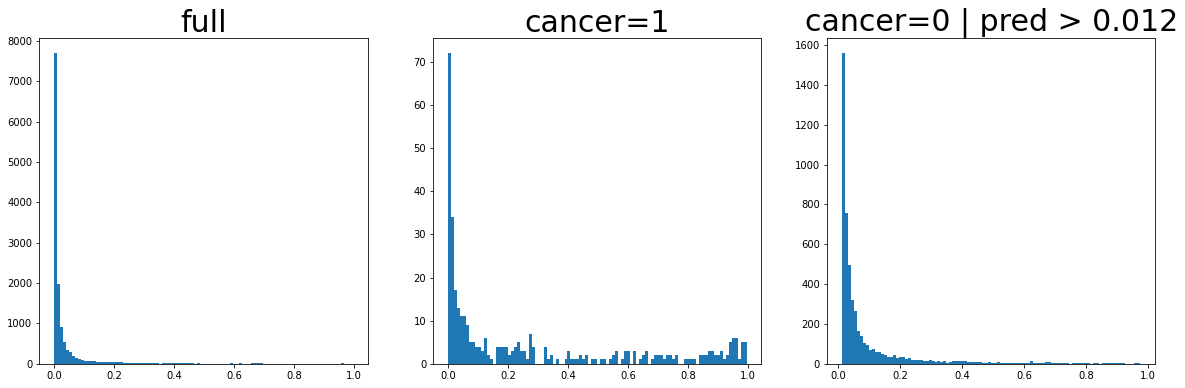

avg_val_loss: 0.53441 val_score: 0.30333 raw_score: 0.21100
INFO:RSNA_utils.utils:avg_val_loss: 0.53441 val_score: 0.30333 raw_score: 0.21100
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 41002


Ep.5 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.315, 'score': 0.3858267716535433}
Best RAW score: 0.2015855271585961
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.43, 'score': 0.2824675324675324}
Best RAW score: 0.1907118441487042
PLOT FOR BASE


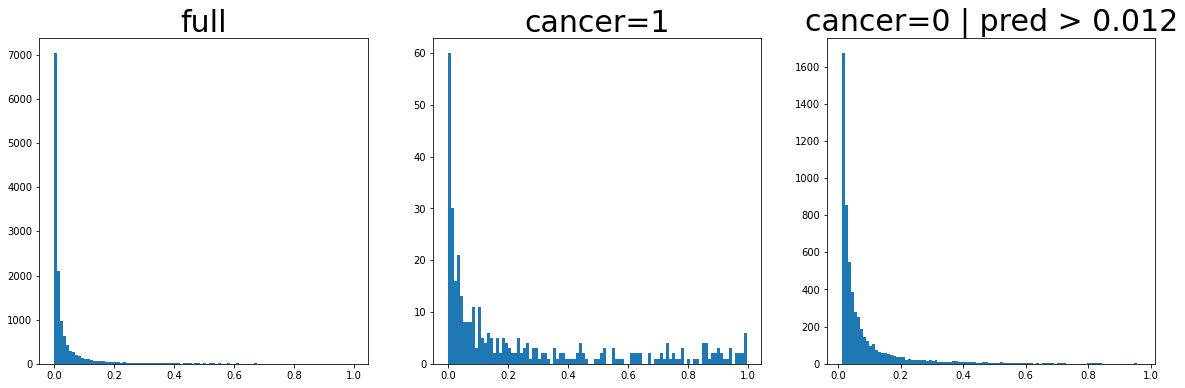

avg_val_loss: 0.50465 val_score: 0.28247 raw_score: 0.19071
INFO:RSNA_utils.utils:avg_val_loss: 0.50465 val_score: 0.28247 raw_score: 0.19071
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Ep.5 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.335, 'score': 0.39370078740157477}
Best RAW score: 0.24519181640103413
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.47500000000000003, 'score': 0.2951388888888889}
Best RAW score: 0.2234832161528777
PLOT FOR BASE


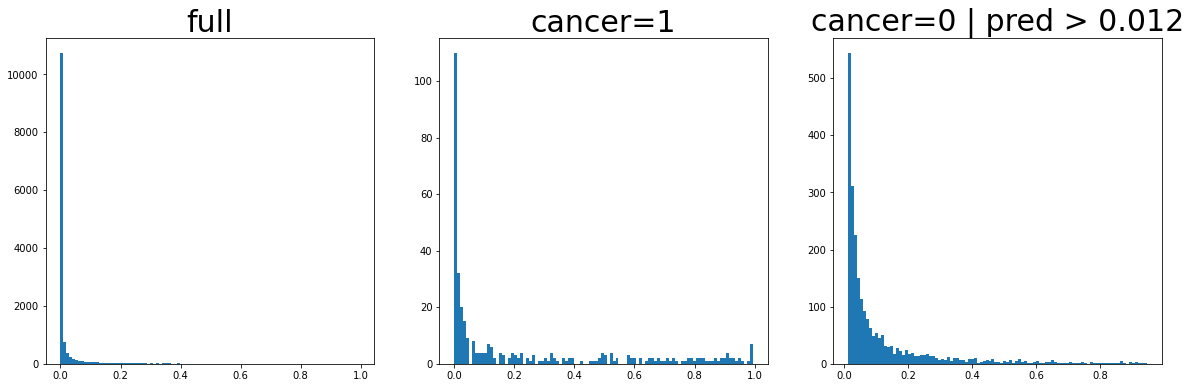

Epoch 5 - avg_train_loss: 0.19848  avg_val_loss: 0.68979  time: 5078s
INFO:RSNA_utils.utils:Epoch 5 - avg_train_loss: 0.19848  avg_val_loss: 0.68979  time: 5078s
Epoch 5 - Score: 0.29514 | RAW score: 0.22348
INFO:RSNA_utils.utils:Epoch 5 - Score: 0.29514 | RAW score: 0.22348
Best RAW Score Updated 0.21289 -->> 0.22348 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.21289 -->> 0.22348 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.47500000000000003, 'score': 0.2951388888888889}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.47500000000000003, 'score': 0.2951388888888889}
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Epoch 6/8 | Fold 1


Ep.6 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Eval on step: 45318


Ep.6 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.34, 'score': 0.40287769784172656}
Best RAW score: 0.2326973365625908
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.43, 'score': 0.300709219858156}
Best RAW score: 0.21844683167767365
PLOT FOR BASE


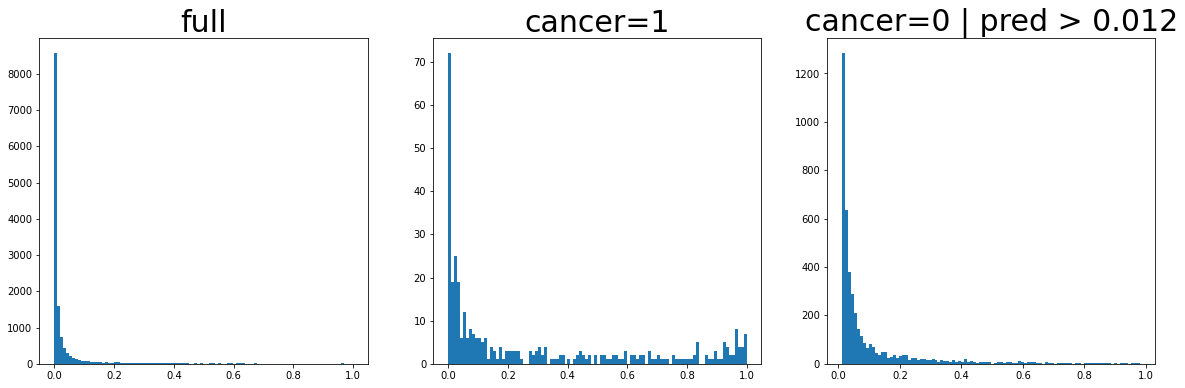

avg_val_loss: 0.55023 val_score: 0.30071 raw_score: 0.21845
INFO:RSNA_utils.utils:avg_val_loss: 0.55023 val_score: 0.30071 raw_score: 0.21845
Score NOT updated. Current best: 0.3162
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3162


Eval on step: 47476


Ep.6 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'median', 'variant': 2, 'threshold': 0.34500000000000003, 'score': 0.4182509505703422}
Best RAW score: 0.26636969280161393
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.32392273402674593}
Best RAW score: 0.2439589122024249
PLOT FOR BASE


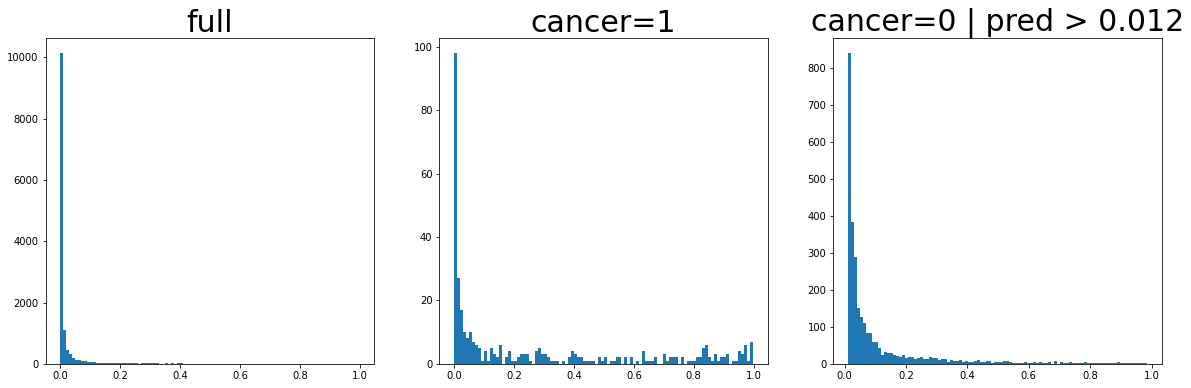

avg_val_loss: 0.58723 val_score: 0.32392 raw_score: 0.24396
INFO:RSNA_utils.utils:avg_val_loss: 0.58723 val_score: 0.32392 raw_score: 0.24396
Best RAW Score Updated 0.22348 -->> 0.24396 | Model Saved
INFO:RSNA_utils.utils:Best RAW Score Updated 0.22348 -->> 0.24396 | Model Saved
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.32392273402674593}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.32392273402674593}
||||| Best Score Updated 0.31619 -->> 0.32392 | Model Saved |||||
INFO:RSNA_utils.utils:||||| Best Score Updated 0.31619 -->> 0.32392 | Model Saved |||||
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.32392273402674593}
INFO:RSNA_utils.utils:Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.32392273402674593}


Eval on step: 49634


Ep.6 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.395, 'score': 0.43678160919540227}
Best RAW score: 0.23801996976696518
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.5800000000000001, 'score': 0.31596638655462184}
Best RAW score: 0.22564652524001796
PLOT FOR BASE


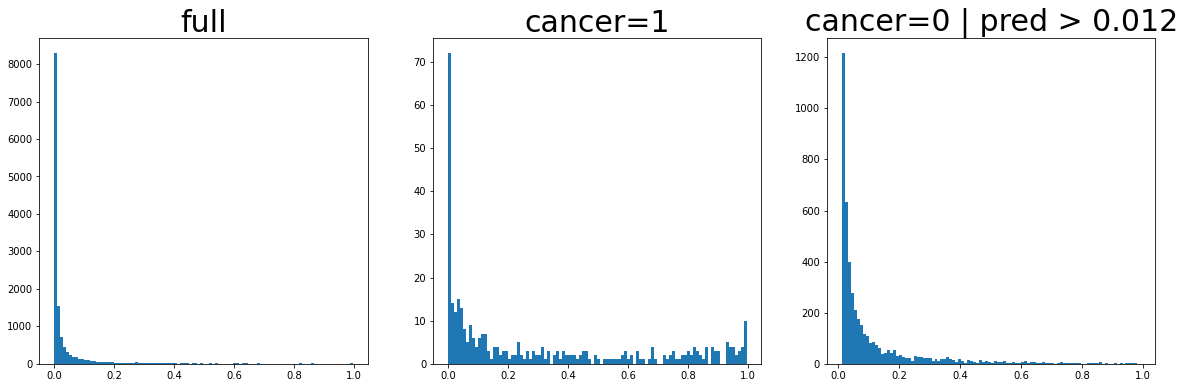

avg_val_loss: 0.51736 val_score: 0.31597 raw_score: 0.22565
INFO:RSNA_utils.utils:avg_val_loss: 0.51736 val_score: 0.31597 raw_score: 0.22565
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Ep.6 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.36, 'score': 0.4088888888888889}
Best RAW score: 0.26098953683582926
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.215, 'score': 0.31283422459893045}
Best RAW score: 0.2281668615099378
PLOT FOR BASE


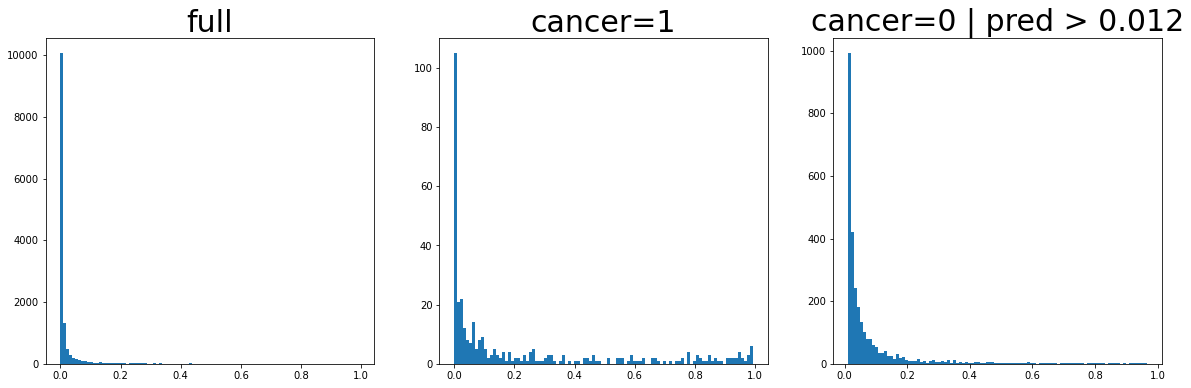

Epoch 6 - avg_train_loss: 0.14018  avg_val_loss: 0.57340  time: 5078s
INFO:RSNA_utils.utils:Epoch 6 - avg_train_loss: 0.14018  avg_val_loss: 0.57340  time: 5078s
Epoch 6 - Score: 0.31283 | RAW score: 0.22817
INFO:RSNA_utils.utils:Epoch 6 - Score: 0.31283 | RAW score: 0.22817
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Epoch 7/8 | Fold 1


Ep.7 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Eval on step: 53950


Ep.7 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.255, 'score': 0.3914590747330961}
Best RAW score: 0.24037936190861886
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.32, 'score': 0.2993630573248408}
Best RAW score: 0.21211212080822933
PLOT FOR BASE


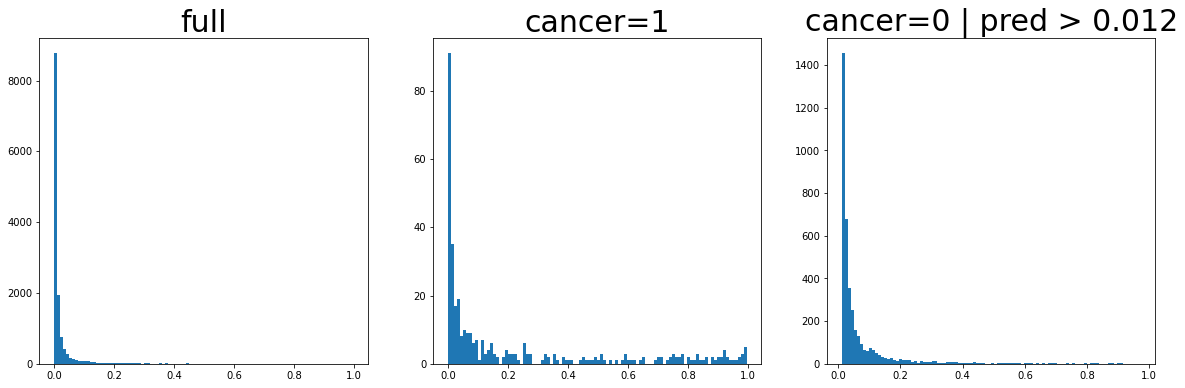

avg_val_loss: 0.55352 val_score: 0.29936 raw_score: 0.21211
INFO:RSNA_utils.utils:avg_val_loss: 0.55352 val_score: 0.29936 raw_score: 0.21211
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Eval on step: 56108


Ep.7 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.24000000000000002, 'score': 0.41353383458646614}
Best RAW score: 0.24615690057666792
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.275, 'score': 0.3127035830618893}
Best RAW score: 0.20926833619837745
PLOT FOR BASE


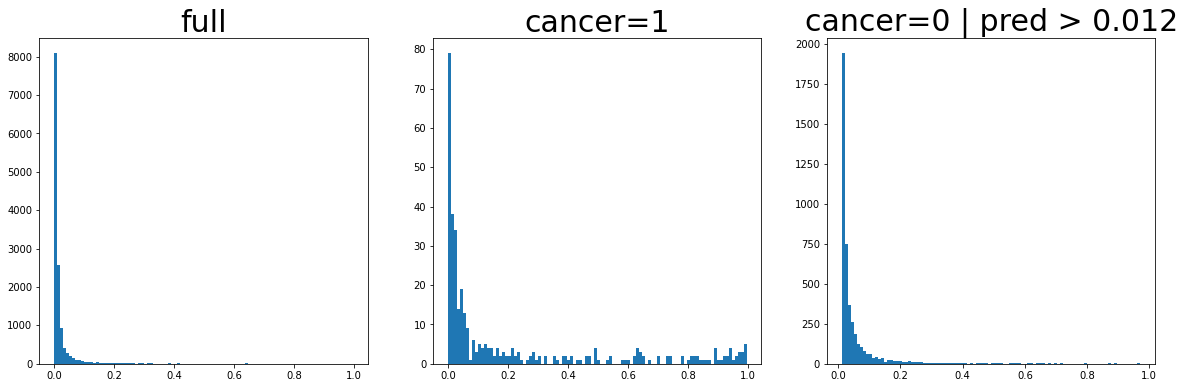

avg_val_loss: 0.53809 val_score: 0.31270 raw_score: 0.20927
INFO:RSNA_utils.utils:avg_val_loss: 0.53809 val_score: 0.31270 raw_score: 0.20927
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Eval on step: 58266


Ep.7 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.32, 'score': 0.4044943820224719}
Best RAW score: 0.24327944207375185
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.535, 'score': 0.3071297989031078}
Best RAW score: 0.22599420983049454
PLOT FOR BASE


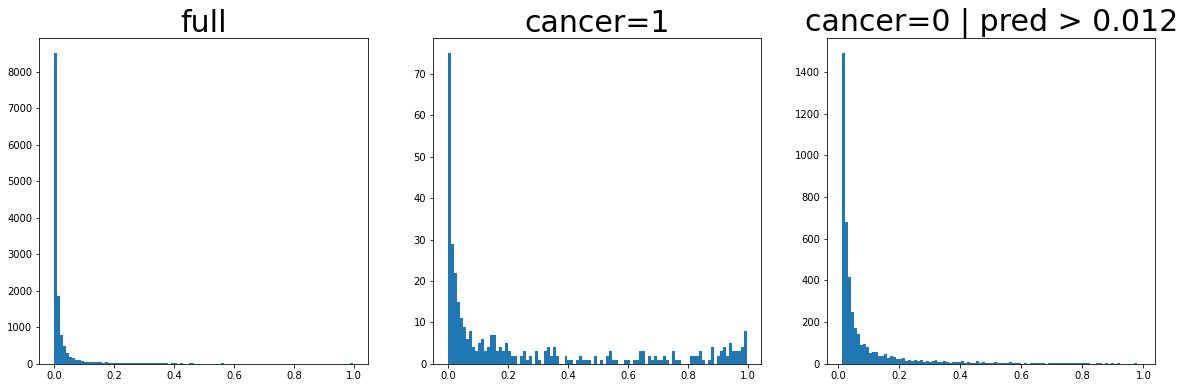

avg_val_loss: 0.51908 val_score: 0.30713 raw_score: 0.22599
INFO:RSNA_utils.utils:avg_val_loss: 0.51908 val_score: 0.30713 raw_score: 0.22599
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Ep.7 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'max', 'variant': 2, 'threshold': 0.4, 'score': 0.3893129770992366}
Best RAW score: 0.2407611049473397
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.27, 'score': 0.2882882882882883}
Best RAW score: 0.19834447617889286
PLOT FOR BASE


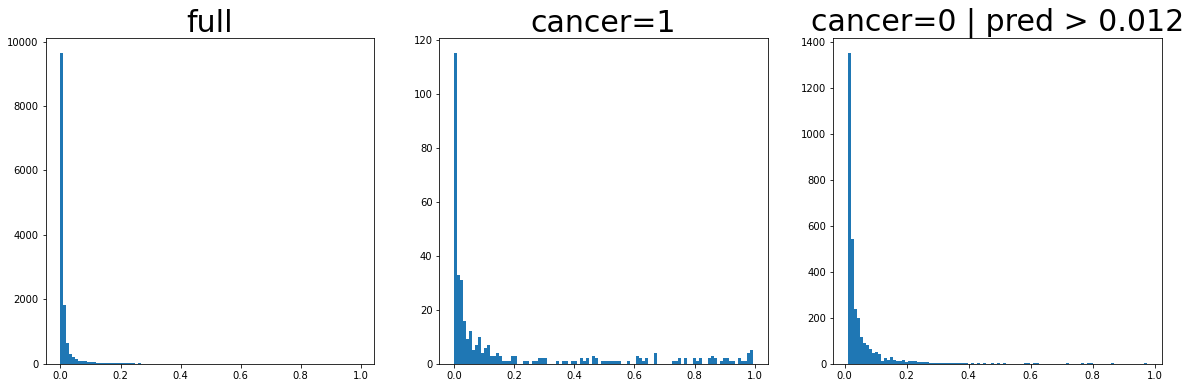

Epoch 7 - avg_train_loss: 0.10080  avg_val_loss: 0.60757  time: 5080s
INFO:RSNA_utils.utils:Epoch 7 - avg_train_loss: 0.10080  avg_val_loss: 0.60757  time: 5080s
Epoch 7 - Score: 0.28829 | RAW score: 0.19834
INFO:RSNA_utils.utils:Epoch 7 - Score: 0.28829 | RAW score: 0.19834
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Epoch 8/8 | Fold 1


Ep.8 Train :   0%|          | 0/8632 [00:00<?, ?it/s]

Eval on step: 62582


Ep.8 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.305, 'score': 0.38493723849372385}
Best RAW score: 0.26503594733842045
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.385, 'score': 0.2954954954954955}
Best RAW score: 0.22826063257734702
PLOT FOR BASE


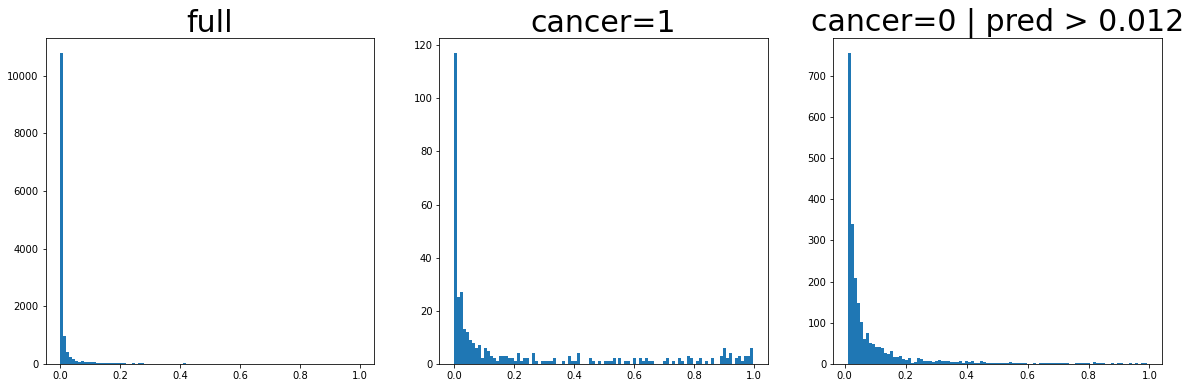

avg_val_loss: 0.63796 val_score: 0.29550 raw_score: 0.22826
INFO:RSNA_utils.utils:avg_val_loss: 0.63796 val_score: 0.29550 raw_score: 0.22826
Score NOT updated. Current best: 0.3239
INFO:RSNA_utils.utils:Score NOT updated. Current best: 0.3239


Eval on step: 64740


Ep.8 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/router_sock.py", line 26, in _read_message
    resp = self._sock_client.read_server_response(timeout=1)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/sock_client.py", line 283, in read_server_response
    data = self._read_packet_bytes(timeout=timeout)
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/lib/sock_client.py", line 269, in _read_packet_bytes
    raise SockClientClosedError()
wandb.sdk.lib.sock_client.SockClientClosedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/router.py", line 70, in message_loop
    msg = self._read_message()
  File "/usr/local/lib/python3.8/dist-packages/wandb/sdk/interface/router_sock.py", line 28, in _read_message
    raise MessageRouterClosedError
wandb.sdk.interface.router.Mess

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.23, 'score': 0.3863636363636364}
Best RAW score: 0.2664897433984368
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.24000000000000002, 'score': 0.3104}
Best RAW score: 0.22478990734826412
PLOT FOR BASE


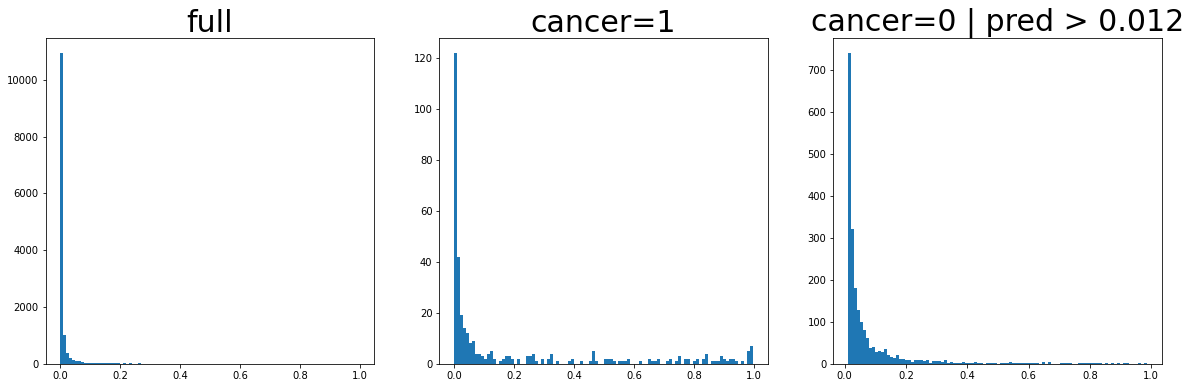

avg_val_loss: 0.64403 val_score: 0.31040 raw_score: 0.22479
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/usr/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/as

Eval on step: 66898


Ep.8 Eval :   0%|          | 0/1701 [00:00<?, ?it/s]

Best params: {'agg': 'mean', 'variant': 2, 'threshold': 0.255, 'score': 0.40151515151515155}
Best RAW score: 0.26441897571423645
SINGLE METRICS:
Best params: {'agg': 'Single', 'variant': 2, 'threshold': 0.28500000000000003, 'score': 0.3108974358974359}
Best RAW score: 0.2302410375621567
PLOT FOR BASE


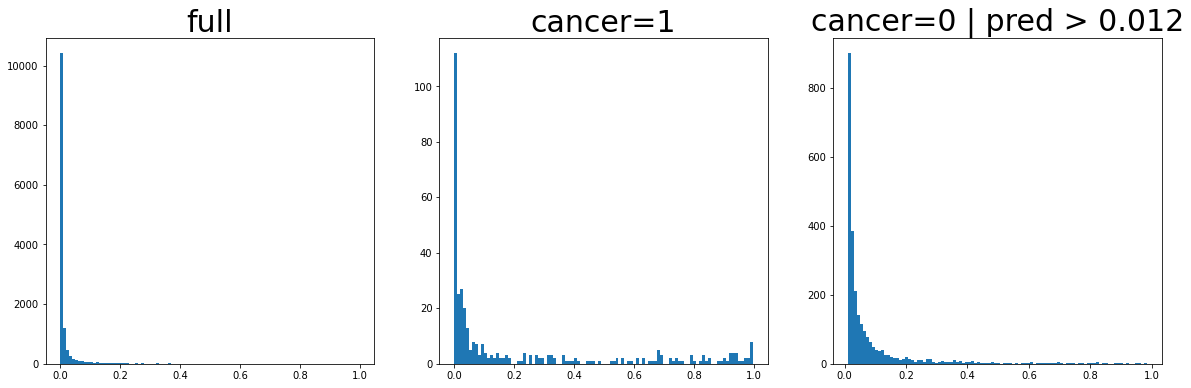

avg_val_loss: 0.61398 val_score: 0.31090 raw_score: 0.23024
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/usr/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/as

In [ ]:
if CFG.train:
    if CFG.FULL_TRAIN:
        LOGGER = get_logger(CFG.base_path + 'results/' + CFG.exp_name + '/train_full')
        train_loop_full_set(CFG, train, LOGGER)
    else:
        for fold_ in CFG.trn_fold:
            LOGGER = get_logger(CFG.base_path + 'results/' + CFG.exp_name + f'/train_f{fold_}')
            train_loop(CFG, train, fold_, LOGGER)
